### Read this before executing notebook

This uses the updated/refactored `fit2d` code. Make sure it's installed by doing the following.

1) `git pull` the little things repo

2) `cd fit2d` from the base path of the little things repo

3) `git pull` *note this is done in the fit2d dir*

4) `pip install -e .`*note this is done in the fit2d dir`

In [1]:
%matplotlib inline

from astropy.io import fits
from copy import copy
import matplotlib.pyplot as plt

from fit2d import Galaxy, RingModel
from fit2d.models import PiecewiseModel
from fit2d._velocity_field_generator import create_2d_velocity_field
from fit2d.mcmc._likelihood import _piecewise_constant, chisq_2d

/home/anna/anaconda3/envs/little/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
# adjust the params and file paths to the galaxy you are looking at

name = "UGC3974"
distance = 8000. # [kpc]
observed_2d_vel_field_fits_file = "/home/anna/Desktop/fit2d/data/UGC3974_1mom.fits"
deg_per_pixel=4.17e-4
v_systemic=270. 

ring_param_file = "/home/anna/Desktop/fit2d/data/UGC3974_ring_parameters.txt"
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic, 
)

ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)

piecewise_model = PiecewiseModel(num_bins=10)
piecewise_model.set_bounds(0, 100)
piecewise_model.set_bin_edges(rmin=ring_model.radii_kpc[0], rmax=ring_model.radii_kpc[-1])


In [8]:

def simulate_velocity_field(params, mask_sigma, ring_model, piecewise_model, galaxy):
    # this basically copies what the likelihhod does in simulating the velocity field
    v_m = _piecewise_constant(
        params, 
        radii_to_interpolate=ring_model.radii_kpc,
        piecewise_model=piecewise_model)
    return create_2d_velocity_field(
            radii=ring_model.radii_kpc,
            v_rot=v_m,
            ring_model=ring_model,
            kpc_per_pixel=galaxy.kpc_per_pixel,
            v_systemic=galaxy.v_systemic,
            image_xdim=galaxy.image_xdim,
            image_ydim=galaxy.image_ydim,
            n_interp_r=150,
            n_interp_theta=150,
            mask_sigma=mask_sigma,
        )

In [10]:
# some guess of velocities as params in the piecewise model. 
# change this to be something like the final fit values in your piecewise fitting
bin_center_velocities_0 = [40.-2*i for i in range(piecewise_model.num_bins)]

bin_center_velocities_1 = copy(bin_center_velocities_0)
# This line changes the sixth ring's velocity in the piecewise model by +20 km/s
# adjust as necessary (e.g. change it by the velocity uncertainty per pixel)
bin_center_velocities_1[5] = bin_center_velocities_0[5] + 20

mask_sigma=1. # gaussian kernel width that determines which empty pixels are eligible to be imputed
vfield0 = simulate_velocity_field(bin_center_velocities_0, mask_sigma, ring_model, piecewise_model, galaxy)
vfield1 = simulate_velocity_field(bin_center_velocities_1, mask_sigma, ring_model, piecewise_model, galaxy)

This plots the simulated velocity field for two sets of parameters.

/home/anna/anaconda3/envs/little/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anna/anaconda3/envs/little/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


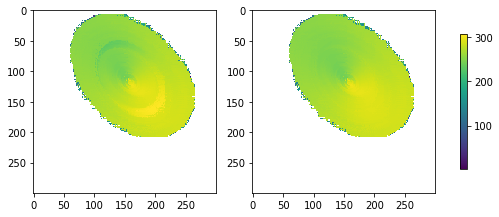

In [11]:
crop_range = [slice(350,650), slice(350,650)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
im = axes[0].imshow(vfield1[crop_range])
clim=im.properties()['clim']
axes[1].imshow(vfield0[crop_range], clim=clim)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)


This shows the difference between the two fields. Adjust vmin/vmax args as necessary to get the colorbar range.

/home/anna/anaconda3/envs/little/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


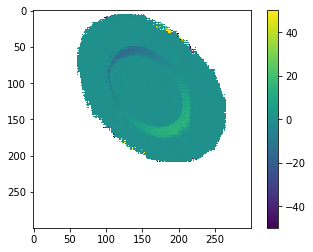

In [12]:
plt.imshow(vfield1[crop_range]-vfield0[crop_range], vmin=-50, vmax=50)
plt.colorbar()

In [19]:
# can adjust v_err_const to see how it affects the Chi2 value
v_err_const = 10.  # [km/s]


chi2_0 = chisq_2d(
    vlos_2d_model=vfield0,
    vlos_2d_obs=galaxy.observed_2d_vel_field,
    v_err_const=v_err_const
    )
chi2_1 = chisq_2d(
    vlos_2d_model=vfield1,
    vlos_2d_obs=galaxy.observed_2d_vel_field,
    v_err_const=v_err_const
    )

chi2_diff = chi2_1 - chi2_0
print("Chi^2 difference: ", chi2_diff)

Chi^2 difference:  7085.941240609056
